In [96]:

from torch.cuda.amp import autocast, GradScaler
import torch.nn as nn
import torch.nn.functional as F
import torch
import os
import random
import numpy as np
import transformers
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchvision.ops import MLP

def seed_everything(seed: int, device: str):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if device == "cuda":
        torch.cuda.manual_seed_all(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    transformers.set_seed(seed)

In [102]:


class ProTCL(nn.Module):
    def __init__(
        self,
        protein_embedding_dim=1100,
        label_embedding_dim=1024,
        latent_dim=1024,
        label_encoder=None,
        sequence_encoder=None,
        train_label_encoder=False,
        train_sequence_encoder=False,
        output_mlp_hidden_dim_scale_factor=1,
        output_mlp_num_layers=2,
        output_neuron_bias=None,
        output_mlp_normalization = 'BN',
        label_batch_size_limit=float("inf"),
        sequence_batch_size_limit=float("inf"),
    ):
        super().__init__()

        # Training options
        train_label_encoder, train_sequence_encoder = train_label_encoder, train_sequence_encoder

        # Encoders
        label_encoder, sequence_encoder = label_encoder, sequence_encoder

        # Batch size limits
        label_batch_size_limit,  sequence_batch_size_limit = label_batch_size_limit, sequence_batch_size_limit

        # Projection heads
        self.W_p = nn.Linear(protein_embedding_dim, latent_dim, bias=False)
        self.W_l = nn.Linear(label_embedding_dim, latent_dim, bias=False)

        # TODO: This could change. Currently keeping latent dim.
        self.output_layer = get_mlp(
            input_dim=latent_dim*2,
            hidden_dim=int(round(output_mlp_hidden_dim_scale_factor*latent_dim)),
            num_layers=output_mlp_num_layers,
            output_neuron_bias=output_neuron_bias,
            normalization=output_mlp_normalization
        )

    def _get_joint_embeddings(self, P_e, L_e):
        num_sequences = P_e.shape[0]
        num_labels = L_e.shape[0]
        sequence_embedding_dim = P_e.shape[1]
        label_embedding_dim = L_e.shape[1]

        # Use broadcasting so we don't have to expand the tensor dimensions
        joint_embeddings = torch.cat([
            P_e[:, None, :].expand(
                num_sequences, num_labels, sequence_embedding_dim),
            L_e[None, :, :].expand(
                num_sequences, num_labels, label_embedding_dim)
        ], dim=2).reshape(-1, sequence_embedding_dim + label_embedding_dim)

        return joint_embeddings, num_sequences, num_labels

    def forward(
        self,
        sequence_onehots=None,
        sequence_embeddings=None,
        sequence_lengths=None,
        tokenized_labels=None,
        label_embeddings=None
    ):
        """
        Forward pass of the model.
        Returns a representation of the similarity between each sequence and each label.
        args:
            sequence_onehots (optional): Tensor of one-hot encoded protein sequences.
            sequence_embeddings (optional): Tensor of pre-trained sequence embeddings.
            sequence_lengths (optional): Tensor of sequence lengths.
            tokenized_labels (optional): List of tokenized label sequences.
            label_embeddings (optional): Tensor of pre-trained label embeddings.
        """

        # If label embeddings are provided and we're not training the laebel encoder, use them. Otherwise, compute them.
        
        L_f = label_embeddings

        # If sequence embeddings are provided and we're not training the sequence encoder, use them. Otherwise, compute them.
        
        P_f = sequence_embeddings

        # Project protein and label embeddings to common latent space.

        P_e = self.W_p(P_f)
        L_e = self.W_l(L_f)

        # Get concatenated embeddings, representing all possible combinations of protein and label embeddings
        # (number proteins * number labels by latent_dim*2)
        joint_embeddings, num_sequences, num_labels = self._get_joint_embeddings(
            P_e, L_e)

        # Feed through MLP to get logits (which represent similarities)
        logits = self.output_layer(joint_embeddings)

        # Reshape for loss function
        logits = logits.reshape(num_sequences, num_labels)
        
        
        return logits,joint_embeddings.detach()


def get_mlp(input_dim,
            hidden_dim,
            num_layers,
            normalization = 'BN',
            output_neuron_bias=None):
    """
    Creates a variable length MLP with ReLU activations.
    """
    layers = []
    
    
    if normalization == 'BN':
        norm = nn.BatchNorm1d
    elif normalization == 'LN':
        norm = nn.LayerNorm
    elif normalization is None:
        norm = nn.Identity

    for idx in range(num_layers):
        if idx ==0:
            layers.append(nn.Linear(input_dim, hidden_dim))
        else:
            layers.append(nn.Linear(hidden_dim, hidden_dim))

        layers.append(norm([hidden_dim]))

        layers.append(nn.ReLU())
        
    output_neuron = nn.Linear(hidden_dim, 1)
    if output_neuron_bias is not None:
        # Set the bias of the final linear layer
        output_neuron.bias.data.fill_(output_neuron_bias)
    layers.append(output_neuron)
    return nn.Sequential(*layers)


In [103]:
dummy_seq_embs = torch.load('../seq_emb_test.pt')
dummy_label_embs = torch.load('../label_emb_test.pt')
dummy_labels = torch.load('../label_multihots_test.pt')

In [104]:
dummy_seq_embs.mean(axis=0).mean(),dummy_seq_embs.std(axis=0).mean()

(tensor(-0.0744, device='cuda:0'), tensor(0.9251, device='cuda:0'))

In [105]:
dummy_label_embs.mean(axis=0).mean(),dummy_label_embs.std(axis=0).mean()

(tensor(-0.0047, device='cuda:0'), tensor(0.5673, device='cuda:0'))

In [106]:
dummy_seq_embs.mean(axis=0).shape

torch.Size([1100])

  0%|          | 0/100 [00:00<?, ?it/s]

 53%|█████▎    | 53/100 [00:00<00:00, 261.52it/s]

epoch 0, loss 0.693
epoch 1, loss 0.689
epoch 2, loss 0.701
epoch 3, loss 0.674
epoch 4, loss 0.672
epoch 5, loss 0.646
epoch 6, loss 0.627
epoch 7, loss 0.593
epoch 8, loss 0.577
epoch 9, loss 0.586
epoch 10, loss 0.507
epoch 11, loss 0.503
epoch 12, loss 0.452
epoch 13, loss 0.417
epoch 14, loss 0.346
epoch 15, loss 0.269
epoch 16, loss 0.250
epoch 17, loss 0.346
epoch 18, loss 0.227
epoch 19, loss 0.164
epoch 20, loss 0.114
epoch 21, loss 0.142
epoch 22, loss 0.063
epoch 23, loss 0.084
epoch 24, loss 0.063
epoch 25, loss 0.043
epoch 26, loss 0.034
epoch 27, loss 0.022
epoch 28, loss 0.024
epoch 29, loss 0.013
epoch 30, loss 0.006
epoch 31, loss 0.004
epoch 32, loss 0.003
epoch 33, loss 0.002
epoch 34, loss 0.002
epoch 35, loss 0.001
epoch 36, loss 0.001
epoch 37, loss 0.000
epoch 38, loss 0.000
epoch 39, loss 0.000
epoch 40, loss 0.000
epoch 41, loss 0.000
epoch 42, loss 0.000
epoch 43, loss 0.000
epoch 44, loss 0.000
epoch 45, loss 0.000
epoch 46, loss 0.000
epoch 47, loss 0.000
ep

100%|██████████| 100/100 [00:00<00:00, 260.74it/s]


epoch 53, loss 0.000
epoch 54, loss 0.000
epoch 55, loss 0.000
epoch 56, loss 0.000
epoch 57, loss 0.000
epoch 58, loss 0.000
epoch 59, loss 0.000
epoch 60, loss 0.000
epoch 61, loss 0.000
epoch 62, loss 0.000
epoch 63, loss 0.000
epoch 64, loss 0.000
epoch 65, loss 0.000
epoch 66, loss 0.000
epoch 67, loss 0.000
epoch 68, loss 0.000
epoch 69, loss 0.000
epoch 70, loss 0.000
epoch 71, loss 0.000
epoch 72, loss 0.000
epoch 73, loss 0.000
epoch 74, loss 0.000
epoch 75, loss 0.000
epoch 76, loss 0.000
epoch 77, loss 0.000
epoch 78, loss 0.000
epoch 79, loss 0.000
epoch 80, loss 0.000
epoch 81, loss 0.000
epoch 82, loss 0.000
epoch 83, loss 0.000
epoch 84, loss 0.000
epoch 85, loss 0.000
epoch 86, loss 0.000
epoch 87, loss 0.000
epoch 88, loss 0.000
epoch 89, loss 0.000
epoch 90, loss 0.000
epoch 91, loss 0.000
epoch 92, loss 0.000
epoch 93, loss 0.000
epoch 94, loss 0.000
epoch 95, loss 0.000
epoch 96, loss 0.000
epoch 97, loss 0.000
epoch 98, loss 0.000
epoch 99, loss 0.000


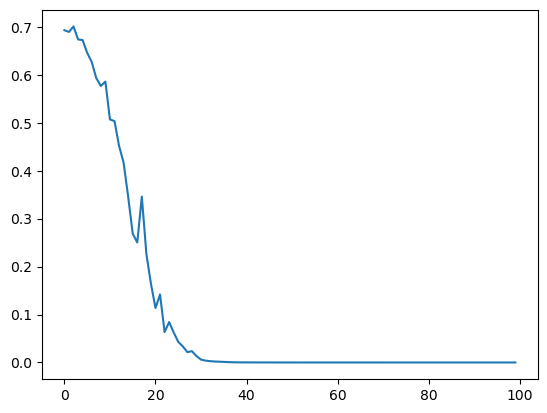

In [130]:
seed_everything(42,'cuda')
#TODO: REMOVE THIS
device = 'cuda'

dummy_seq_embs = torch.load('../seq_emb_test.pt')
dummy_label_embs = torch.load('../label_emb_test.pt')
dummy_labels = torch.load('../label_multihots_test.pt')


num_labels =100
#dummy_seq_embs = torch.rand((38,1100),device=device)
#dummy_label_embs = torch.rand((num_labels,1100),device=device)
#dummy_labels = (torch.rand((38,num_labels),device=device)>=0.5).long()


#dummy_seq_embs = (dummy_seq_embs - dummy_seq_embs.mean(axis=0))/dummy_seq_embs.std(axis=0)
#dummy_label_embs = (dummy_label_embs - dummy_label_embs.mean(axis=0))/dummy_label_embs.std(axis=0)

model = ProTCL(
        protein_embedding_dim=dummy_seq_embs.shape[1],
        label_embedding_dim=dummy_label_embs.shape[1],
        latent_dim=1024,
        output_mlp_num_layers=4,
        output_mlp_hidden_dim_scale_factor=2,
        output_mlp_normalization=None

    ).to(device)
criterion = torch.nn.BCEWithLogitsLoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
model.train()



NUM_EPOCHS = 100
gradient_accumulation_steps=1
clip_value=1
scaler = GradScaler()
training_step=0
losses = []
all_joint_embeddings = []
accuracies = []
for epoch in tqdm(range(NUM_EPOCHS)):
    
    
    training_step+=1
    correct = 0
    with autocast():
        logits,joint_embeddings = model(sequence_embeddings=dummy_seq_embs,label_embeddings=dummy_label_embs)

        # Compute loss, normalized by the number of gradient accumulation steps
        loss = criterion(logits, dummy_labels.float())  / \
            gradient_accumulation_steps

    
    accuracies.append((((torch.sigmoid(logits)>0.5)*1==dummy_labels)*1.0).mean().item())

    all_joint_embeddings.append(joint_embeddings.detach().mean(axis=0).mean().item())
    
    # Backward pass with mixed precision
    scaler.scale(loss).backward()

    # Gradient accumulation every GRADIENT_ACCUMULATION_STEPS
    if (training_step % gradient_accumulation_steps == 0):
        
        # Unscales the gradients of optimizer's assigned params in-place
        scaler.unscale_(optimizer)
        
        # Apply gradient clipping
        torch.nn.utils.clip_grad_value_(model.parameters(), clip_value=clip_value)
        
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()
                
        print("epoch {}, loss {:.3f}".format(epoch, loss.item()))
        losses.append(loss.item())

    
plt.plot(losses)
plt.show()


In [111]:
dummy_labels.shape

torch.Size([38, 10])

tensor(1., device='cuda:0')

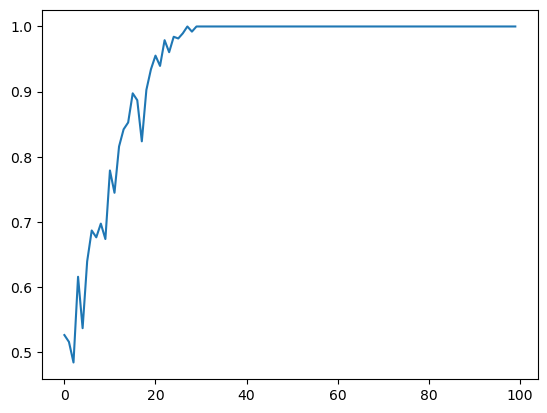

In [131]:
plt.plot(accuracies)

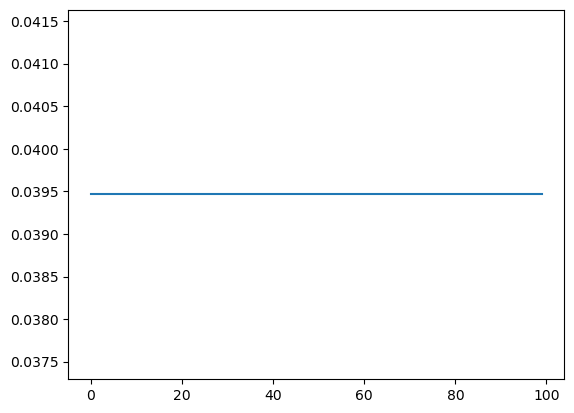

In [48]:
plt.plot([i[0] for i in all_joint_embeddings])

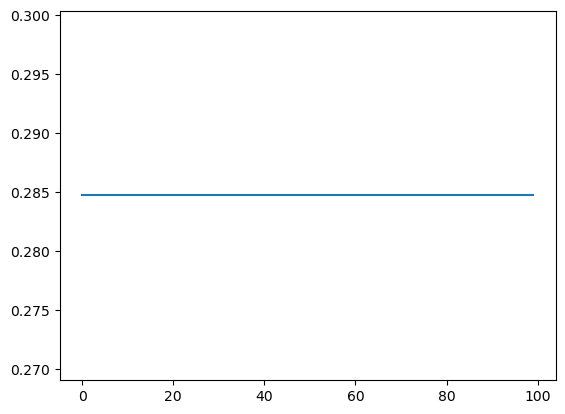

In [40]:
plt.plot([i[1] for i in all_joint_embeddings])

In [120]:
 (torch.rand((38,num_labels),device=device)>=1/670).long().sum()

tensor(378, device='cuda:0')

  0%|          | 0/100 [00:00<?, ?it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 283.31it/s]

epoch 0, loss 0.693
epoch 1, loss 0.688
epoch 2, loss 0.682
epoch 3, loss 0.674
epoch 4, loss 0.663
epoch 5, loss 0.649
epoch 6, loss 0.632
epoch 7, loss 0.613
epoch 8, loss 0.594
epoch 9, loss 0.579
epoch 10, loss 0.565
epoch 11, loss 0.552
epoch 12, loss 0.536
epoch 13, loss 0.516
epoch 14, loss 0.494
epoch 15, loss 0.470
epoch 16, loss 0.444
epoch 17, loss 0.418
epoch 18, loss 0.392
epoch 19, loss 0.365
epoch 20, loss 0.337
epoch 21, loss 0.309
epoch 22, loss 0.282
epoch 23, loss 0.255
epoch 24, loss 0.231
epoch 25, loss 0.208
epoch 26, loss 0.187
epoch 27, loss 0.167
epoch 28, loss 0.149
epoch 29, loss 0.133
epoch 30, loss 0.120
epoch 31, loss 0.107
epoch 32, loss 0.096
epoch 33, loss 0.085
epoch 34, loss 0.076
epoch 35, loss 0.068
epoch 36, loss 0.062
epoch 37, loss 0.055
epoch 38, loss 0.050
epoch 39, loss 0.044
epoch 40, loss 0.040
epoch 41, loss 0.035
epoch 42, loss 0.032
epoch 43, loss 0.028
epoch 44, loss 0.025
epoch 45, loss 0.022
epoch 46, loss 0.019
epoch 47, loss 0.017
ep

100%|██████████| 100/100 [00:00<00:00, 285.88it/s]


epoch 58, loss 0.003
epoch 59, loss 0.003
epoch 60, loss 0.002
epoch 61, loss 0.002
epoch 62, loss 0.002
epoch 63, loss 0.001
epoch 64, loss 0.001
epoch 65, loss 0.001
epoch 66, loss 0.001
epoch 67, loss 0.001
epoch 68, loss 0.000
epoch 69, loss 0.000
epoch 70, loss 0.000
epoch 71, loss 0.000
epoch 72, loss 0.000
epoch 73, loss 0.000
epoch 74, loss 0.000
epoch 75, loss 0.000
epoch 76, loss 0.000
epoch 77, loss 0.000
epoch 78, loss 0.000
epoch 79, loss 0.000
epoch 80, loss 0.000
epoch 81, loss 0.000
epoch 82, loss 0.000
epoch 83, loss 0.000
epoch 84, loss 0.000
epoch 85, loss 0.000
epoch 86, loss 0.000
epoch 87, loss 0.000
epoch 88, loss 0.000
epoch 89, loss 0.000
epoch 90, loss 0.000
epoch 91, loss 0.000
epoch 92, loss 0.000
epoch 93, loss 0.000
epoch 94, loss 0.000
epoch 95, loss 0.000
epoch 96, loss 0.000
epoch 97, loss 0.000
epoch 98, loss 0.000
epoch 99, loss 0.000


 59%|█████▉    | 59/100 [00:00<00:00, 289.82it/s]

epoch 0, loss 0.693
epoch 1, loss 0.689
epoch 2, loss 0.683
epoch 3, loss 0.675
epoch 4, loss 0.665
epoch 5, loss 0.650
epoch 6, loss 0.632
epoch 7, loss 0.612
epoch 8, loss 0.596
epoch 9, loss 0.597
epoch 10, loss 0.566
epoch 11, loss 0.558
epoch 12, loss 0.537
epoch 13, loss 0.520
epoch 14, loss 0.500
epoch 15, loss 0.474
epoch 16, loss 0.456
epoch 17, loss 0.416
epoch 18, loss 0.398
epoch 19, loss 0.365
epoch 20, loss 0.320
epoch 21, loss 0.295
epoch 22, loss 0.279
epoch 23, loss 0.240
epoch 24, loss 0.193
epoch 25, loss 0.177
epoch 26, loss 0.167
epoch 27, loss 0.127
epoch 28, loss 0.101
epoch 29, loss 0.099
epoch 30, loss 0.074
epoch 31, loss 0.058
epoch 32, loss 0.057
epoch 33, loss 0.038
epoch 34, loss 0.036
epoch 35, loss 0.028
epoch 36, loss 0.020
epoch 37, loss 0.019
epoch 38, loss 0.012
epoch 39, loss 0.011
epoch 40, loss 0.007
epoch 41, loss 0.006
epoch 42, loss 0.005
epoch 43, loss 0.003
epoch 44, loss 0.003
epoch 45, loss 0.002
epoch 46, loss 0.001
epoch 47, loss 0.001
ep

100%|██████████| 100/100 [00:00<00:00, 288.58it/s]


epoch 59, loss 0.000
epoch 60, loss 0.000
epoch 61, loss 0.000
epoch 62, loss 0.000
epoch 63, loss 0.000
epoch 64, loss 0.000
epoch 65, loss 0.000
epoch 66, loss 0.000
epoch 67, loss 0.000
epoch 68, loss 0.000
epoch 69, loss 0.000
epoch 70, loss 0.000
epoch 71, loss 0.000
epoch 72, loss 0.000
epoch 73, loss 0.000
epoch 74, loss 0.000
epoch 75, loss 0.000
epoch 76, loss 0.000
epoch 77, loss 0.000
epoch 78, loss 0.000
epoch 79, loss 0.000
epoch 80, loss 0.000
epoch 81, loss 0.000
epoch 82, loss 0.000
epoch 83, loss 0.000
epoch 84, loss 0.000
epoch 85, loss 0.000
epoch 86, loss 0.000
epoch 87, loss 0.000
epoch 88, loss 0.000
epoch 89, loss 0.000
epoch 90, loss 0.000
epoch 91, loss 0.000
epoch 92, loss 0.000
epoch 93, loss 0.000
epoch 94, loss 0.000
epoch 95, loss 0.000
epoch 96, loss 0.000
epoch 97, loss 0.000
epoch 98, loss 0.000
epoch 99, loss 0.000


 26%|██▌       | 26/100 [00:00<00:00, 253.10it/s]

epoch 0, loss 0.707
epoch 1, loss 0.428
epoch 2, loss 0.317
epoch 3, loss 0.197
epoch 4, loss 0.160
epoch 5, loss 0.106
epoch 6, loss 0.085
epoch 7, loss 0.064
epoch 8, loss 0.043
epoch 9, loss 0.034
epoch 10, loss 0.026
epoch 11, loss 0.019
epoch 12, loss 0.015
epoch 13, loss 0.012
epoch 14, loss 0.009
epoch 15, loss 0.007
epoch 16, loss 0.006
epoch 17, loss 0.005
epoch 18, loss 0.004
epoch 19, loss 0.003
epoch 20, loss 0.003
epoch 21, loss 0.002
epoch 22, loss 0.002
epoch 23, loss 0.002
epoch 24, loss 0.002
epoch 25, loss 0.001
epoch 26, loss 0.001
epoch 27, loss 0.001
epoch 28, loss 0.001
epoch 29, loss 0.001
epoch 30, loss 0.001
epoch 31, loss 0.001
epoch 32, loss 0.001
epoch 33, loss 0.001
epoch 34, loss 0.001
epoch 35, loss 0.001
epoch 36, loss 0.001
epoch 37, loss 0.001
epoch 38, loss 0.001
epoch 39, loss 0.001
epoch 40, loss 0.001
epoch 41, loss 0.000
epoch 42, loss 0.000
epoch 43, loss 0.000
epoch 44, loss 0.000
epoch 45, loss 0.000
epoch 46, loss 0.000
epoch 47, loss 0.000
ep

100%|██████████| 100/100 [00:00<00:00, 260.01it/s]

epoch 53, loss 0.000
epoch 54, loss 0.000
epoch 55, loss 0.000
epoch 56, loss 0.000
epoch 57, loss 0.000
epoch 58, loss 0.000
epoch 59, loss 0.000
epoch 60, loss 0.000
epoch 61, loss 0.000
epoch 62, loss 0.000
epoch 63, loss 0.000
epoch 64, loss 0.000
epoch 65, loss 0.000
epoch 66, loss 0.000
epoch 67, loss 0.000
epoch 68, loss 0.000
epoch 69, loss 0.000
epoch 70, loss 0.000
epoch 71, loss 0.000
epoch 72, loss 0.000
epoch 73, loss 0.000
epoch 74, loss 0.000
epoch 75, loss 0.000
epoch 76, loss 0.000
epoch 77, loss 0.000
epoch 78, loss 0.000
epoch 79, loss 0.000
epoch 80, loss 0.000
epoch 81, loss 0.000
epoch 82, loss 0.000
epoch 83, loss 0.000
epoch 84, loss 0.000
epoch 85, loss 0.000
epoch 86, loss 0.000
epoch 87, loss 0.000
epoch 88, loss 0.000
epoch 89, loss 0.000
epoch 90, loss 0.000
epoch 91, loss 0.000
epoch 92, loss 0.000
epoch 93, loss 0.000
epoch 94, loss 0.000
epoch 95, loss 0.000
epoch 96, loss 0.000
epoch 97, loss 0.000
epoch 98, loss 0.000
epoch 99, loss 0.000


[]

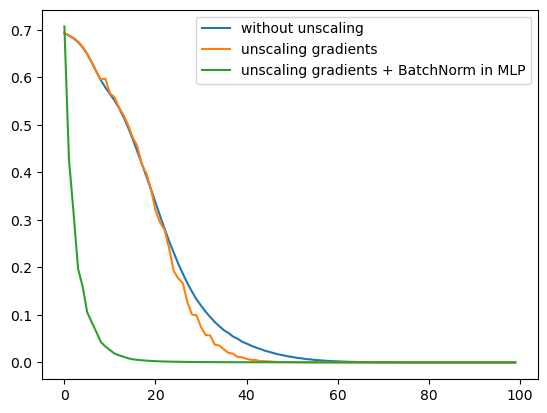

In [152]:
seed_everything(42,'cuda')
#TODO: REMOVE THIS
device = 'cuda'

dummy_seq_embs = torch.load('../seq_emb_test.pt')
dummy_label_embs = torch.load('../label_emb_test.pt')
dummy_labels = torch.load('../label_multihots_test.pt')


num_labels =10
# dummy_seq_embs = torch.rand((38,1100),device=device)
# dummy_label_embs = torch.rand((num_labels,1024),device=device)
# dummy_labels = (torch.rand((38,num_labels),device=device)>=0.5).long()

model = ProTCL(
        protein_embedding_dim=dummy_seq_embs.shape[1],
        label_embedding_dim=dummy_label_embs.shape[1],
        latent_dim=1024,
        output_mlp_num_layers=4,
        output_mlp_hidden_dim_scale_factor=2

    ).to(device)
criterion = torch.nn.BCEWithLogitsLoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
model.train()



NUM_EPOCHS = 100
gradient_accumulation_steps=1
clip_value=.1

scaler = GradScaler()
training_step=0
losses = []
for epoch in tqdm(range(NUM_EPOCHS)):
    
    
    training_step+=1
    
    with autocast():
        logits = model(sequence_embeddings=dummy_seq_embs,label_embeddings=dummy_label_embs)

        # Compute loss, normalized by the number of gradient accumulation steps
        loss = criterion(logits, dummy_labels.float())  / \
            gradient_accumulation_steps

    # Backward pass with mixed precision
    scaler.scale(loss).backward()

    # Gradient accumulation every GRADIENT_ACCUMULATION_STEPS
    if (training_step % gradient_accumulation_steps == 0):
        
        # Unscales the gradients of optimizer's assigned params in-place
        #scaler.unscale_(optimizer)
        
        # Apply gradient clipping
        torch.nn.utils.clip_grad_value_(model.parameters(), clip_value=clip_value)
        
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()
                
        print("epoch {}, loss {:.3f}".format(epoch, loss.item()))
        losses.append(loss.item())

    
plt.plot(losses,label='without unscaling')

model = ProTCL(
        protein_embedding_dim=dummy_seq_embs.shape[1],
        label_embedding_dim=dummy_label_embs.shape[1],
        latent_dim=1024,
        output_mlp_num_layers=4,
        output_mlp_hidden_dim_scale_factor=2

    ).to(device)
criterion = torch.nn.BCEWithLogitsLoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
model.train()



NUM_EPOCHS = 100
gradient_accumulation_steps=1
clip_value=.1

scaler = GradScaler()
training_step=0
losses = []
for epoch in tqdm(range(NUM_EPOCHS)):
    
    
    training_step+=1
    
    with autocast():
        logits = model(sequence_embeddings=dummy_seq_embs,label_embeddings=dummy_label_embs)

        # Compute loss, normalized by the number of gradient accumulation steps
        loss = criterion(logits, dummy_labels.float())  / \
            gradient_accumulation_steps

    # Backward pass with mixed precision
    scaler.scale(loss).backward()

    # Gradient accumulation every GRADIENT_ACCUMULATION_STEPS
    if (training_step % gradient_accumulation_steps == 0):
        
        # Unscales the gradients of optimizer's assigned params in-place
        scaler.unscale_(optimizer)
        
        # Apply gradient clipping
        torch.nn.utils.clip_grad_value_(model.parameters(), clip_value=clip_value)
        
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()
                
        print("epoch {}, loss {:.3f}".format(epoch, loss.item()))
        losses.append(loss.item())

    
plt.plot(losses,label='unscaling gradients')



model = ProTCL(
        protein_embedding_dim=dummy_seq_embs.shape[1],
        label_embedding_dim=dummy_label_embs.shape[1],
        latent_dim=1024,
        output_mlp_num_layers=4,
        output_mlp_hidden_dim_scale_factor=2,
        outout_mlp_add_batchnorm='BN'


    ).to(device)
criterion = torch.nn.BCEWithLogitsLoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
model.train()



NUM_EPOCHS = 100
gradient_accumulation_steps=1
clip_value=.1

scaler = GradScaler()
training_step=0
losses = []
for epoch in tqdm(range(NUM_EPOCHS)):
    
    
    training_step+=1
    
    with autocast():
        logits = model(sequence_embeddings=dummy_seq_embs,label_embeddings=dummy_label_embs)

        # Compute loss, normalized by the number of gradient accumulation steps
        loss = criterion(logits, dummy_labels.float())  / \
            gradient_accumulation_steps

    # Backward pass with mixed precision
    scaler.scale(loss).backward()

    # Gradient accumulation every GRADIENT_ACCUMULATION_STEPS
    if (training_step % gradient_accumulation_steps == 0):
        
        # Unscales the gradients of optimizer's assigned params in-place
        scaler.unscale_(optimizer)
        
        # Apply gradient clipping
        torch.nn.utils.clip_grad_value_(model.parameters(), clip_value=clip_value)
        
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()
                
        print("epoch {}, loss {:.3f}".format(epoch, loss.item()))
        losses.append(loss.item())

    
plt.plot(losses,label='unscaling gradients + BatchNorm in MLP')



plt.legend()
plt.plot()
